## Programming Exercise 4: Neural Networks Learning
#### Author - Rishabh Jain

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from scipy.io import loadmat

### 1&nbsp;&nbsp;&nbsp;&nbsp;Neural Networks

##### Problem Statement
In the previous exercise, we implemented feedforward propogation for neural networks and used it to predict handwritten digits with the provided weights. **In this exercise, we will implement the backpropogation algorithm to learn the parameters for the neural network.**

We will use the same dataset that we used in the previous exercise. There are 5000 training examples, where each example is 20 X 20 pixel image of a handwritten digit. Each pixel is represented by a floating point number indicating the graysacle intensity at that location. This 20 by 20 grid of pixels is 'unrolled' into a 400 dimensional vector.

In [2]:
# Loading Mat file
mat=loadmat('./ex4data1.mat')
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
y


In [3]:
# Loading data from mat to Dataframe
m,n=mat['X'].shape

data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=mat['X'].T[i]

# Converting label 10 to label 0
data['y']=mat['y']
data.loc[data['y']==10,'y']=0

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
data.sample(5)

TRAINING DATASET SHAPE : 5000 X 401


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x392,x393,x394,x395,x396,x397,x398,x399,x400,y
3880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Visualizing the data

We will begin by visualizing a subset of the training set. We will randomly select 100 rows from X. This function maps each row to a 20 X 20 pixel image and displays together.

In [4]:
def displayData(X):
    m,n=X.shape
    width=int(np.sqrt(n))
    height=int(n/width)
    rows=int(np.floor(np.sqrt(m)))
    cols=int(np.ceil(m/rows))
    totalWidth=cols+cols*width
    displayArray=np.zeros((1,totalWidth))
    rowPadding=np.ones((1,totalWidth))
    colPadding=np.ones((height,1))
    index=0
    for i in range(rows):
        row=colPadding*0
        for j in range(cols):
            if index<m:
                x=X[index].reshape((width,height)).T
                index=index+1
            else:
                x=np.zeros((width,height)).T
            row=np.column_stack((row,x))
            if j<cols-1:
                row=np.column_stack((row,colPadding))
        displayArray=np.row_stack((displayArray,row))
        if i<rows-1:
            displayArray=np.row_stack((displayArray,rowPadding))
    displayArray=np.row_stack((displayArray,rowPadding*0))
    plt.imshow(displayArray,cmap='gray')
    plt.axis('off')

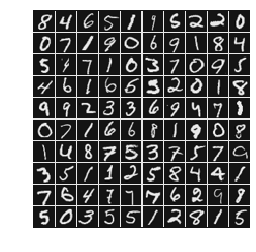

In [5]:
displayData(data.sample(100).iloc[:,:-1].values)

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;Model Representation

<table>
    <tr>
        <td>
            <img src="https://cdn-images-1.medium.com/max/1200/1*uyIJXyLOI4-ETDmcWFsKvQ.png" width="300">
        </td>
        <td>
            <img src="http://ufldl.stanford.edu/tutorial/images/Network331.png" width="300">
        </td>
    </tr>
</table>

$a_i^{(j)}=$ "activation" of unit $i$ in layer $j$  
$\theta^{(j)}=$ matrix of weights controlling function mapping from layer $j$ to layer $j+1$  
$g(x)=$ sigmoid activation function  

**If network has $s_j$ units in layer $j$, $s_{j+1}$ units in layer $j+1$, then $\theta^{(j)}$ will be of dimension $s_{j+1}$ X $(s_j+1)$**


$$ a^{(2)}_1=g(\theta_{10}^{(1)}x_0+\theta_{11}^{(1)}x_1+\theta_{12}^{(1)}x_2+\theta_{13}^{(1)}x_3) $$

$$ a^{(2)}_2=g(\theta_{20}^{(1)}x_0+\theta_{21}^{(1)}x_1+\theta_{22}^{(1)}x_2+\theta_{23}^{(1)}x_3) $$

$$ a^{(2)}_3=g(\theta_{30}^{(1)}x_0+\theta_{31}^{(1)}x_1+\theta_{32}^{(1)}x_2+\theta_{33}^{(1)}x_3) $$


In this exercise, we will be using the parameters from a neural network that is already trained. Our goal is to implement the **Feed-Forward Progration** algorithm for prediction.

In [6]:
# Loading weights
weights=loadmat('./ex4weights.mat')
print(*weights.keys(),sep='\n')

__header__
__version__
__globals__
Theta1
Theta2


The neural network we are about to use has 3 layers - an input layer ($L_1$), a hidden layer ($L_2$) and an output layer ($L_3$). 

* L1 layer has 400 Neuron units (20 X 20 pixel image) excluding the extra bias unit that always output +1
* L2 layer has 25 Neuron units
* L3 layer has 10 Neuron Units

In [7]:
theta1=weights['Theta1']
theta2=weights['Theta2']
print(f'Theta1 : {theta1.shape}')
print(f'Theta2 : {theta2.shape}')

Theta1 : (25, 401)
Theta2 : (10, 26)


#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Feedforward and cost function